# Build a model to classify programming languages

1. Load CSV train and test files
2. Apply text preprocessing
3. Train and select best model
4. Evaluate best and analyze errors
4. Export model to json and torchscript

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt

# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter

In [3]:
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Text prep configs

In [142]:
VOCAB = None  #"./notebooks/vocabulary.txt"
EXTRA_VOCAB = "./data/raw/vocabulary/"
FILTER_VOCAB_CHARS = False
WITH_VOCAB = False
FILTER_NUMBERS = True
FILTER_NONWORD_CHARS = False
REMOVE_COMMENTS = True
REMOVE_URL = True

SPE_TOKENIZER = "./models/trained/tglang_spe_unigram_10000.model"

USE_SPE = False

USE_ONMT = False
ONMT_MODE = "conservative"

TRAIN_DATA = "./data/processed/tglang_train.csv"
TEST_DATA = "./data/processed/tglang_test.csv"

In [5]:
LANG_ENUM = Path("./src/tglang/langs_enum_r2.txt").read_text().strip().split('\n')
LANG_ENUM = [l.strip() for l in LANG_ENUM]

label2id = {l:i for i, l in enumerate(LANG_ENUM)}
id2label = {i:l for l, i in label2id.items()}

len(LANG_ENUM)

29

## Load data

### train, test sets

In [6]:
thestack = pd.read_csv(TRAIN_DATA)
thestack = thestack.loc[~thestack["content"].isna()]
thestack["content"] = thestack["content"].astype(str)
thestack["lang"] = thestack["lang"].astype(str)

thestack.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17947 entries, 0 to 17947
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    17947 non-null  object
 1   lang       17947 non-null  object
 2   num_chars  17947 non-null  int64 
 3   num_lines  17947 non-null  int64 
 4   file       17947 non-null  object
dtypes: int64(2), object(3)
memory usage: 841.3+ KB


In [7]:
test_set = pd.read_csv(TEST_DATA)
test_set = test_set.loc[~test_set["content"].isna()]
test_set["content"] = test_set["content"].astype(str)
test_set["lang"] = test_set["lang"].astype(str)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 985 entries, 0 to 985
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    985 non-null    object
 1   lang       985 non-null    object
 2   num_chars  985 non-null    int64 
 3   num_lines  985 non-null    int64 
 4   file       985 non-null    object
dtypes: int64(2), object(3)
memory usage: 46.2+ KB


### Load vocab

In [8]:
if VOCAB:
    vocab = Path(VOCAB).read_text().strip().split("\n")
    vocab = list(map(lambda x: x.lower().strip(), vocab))

    print("Vocab size:", len(vocab))

    pprint(random.choices(vocab, k=10))
else:
    vocab = []
    print("empty vocab")

empty vocab


#### Extra vocab

In [9]:
if EXTRA_VOCAB:
    extra_files = Path(EXTRA_VOCAB).rglob("*.*")
    extra_vocab = [p.read_text().strip().split('\n') for p in extra_files if bool(p.suffix)]
    extra_vocab = sum(extra_vocab, [])
    extra_vocab = list(map(lambda x: x.lower().strip(), extra_vocab))
else:
    extra_vocab = []

len(extra_vocab)

1372

#### filter vocab

In [10]:
vocab = set(vocab)
vocab.update(extra_vocab)
vocab = list(vocab)

if FILTER_VOCAB_CHARS:
    vocab = list(filter(lambda x: re.search('\w', x), vocab))

len(vocab)

782

### Tokenizer

#### initialize

In [11]:
import functools
import torch
import pyonmttok

In [12]:
from torchtext.transforms import SentencePieceTokenizer

transform_sentpiece = SentencePieceTokenizer(SPE_TOKENIZER)

spe_scripted = torch.jit.script(transform_sentpiece)

In [13]:
%%time

onmt_tokenizer = pyonmttok.Tokenizer(mode=ONMT_MODE, case_feature=False)

CPU times: user 18 µs, sys: 7 µs, total: 25 µs
Wall time: 26.7 µs


In [143]:

def check_vocab(x):
    if x in vocab:
        return True
    else:
        return False
    
def is_not_number(x):
    if re.match('\d+$', x):
        return False
    else:
        return True
    
    
is_not_nonword = lambda x: not re.match('\.|\+|=|"|\'', x)


def remove_comments_and_docstrings(code):
    # Python-style comments (# ...) and docstrings (''' ... ''' or """ ... """)
    code = re.sub(r'#.*', '', code)
    code = re.sub(r"'''[\s\S]*?'''", '', code)
    code = re.sub(r'"""[\s\S]*?"""', '', code)

    # JavaScript-style comments (// ...) and block comments (/* ... */)
    code = re.sub(r'//.*', '', code)
    code = re.sub(r'/\*[\s\S]*?\*/', '', code)

    # C++-style comments (// ...) and block comments (/* ... */)
    code = re.sub(r'//.*', '', code)
    code = re.sub(r'/\*[\s\S]*?\*/', '', code)

    return code


def remove_links(text):
    # Regex pattern to match HTTP and HTTPS links
    link_pattern = r'https?://\S+|www\.\S+'
    
    # Replace links with an empty string
    cleaned_text = re.sub(link_pattern, '', text)
    
    return cleaned_text
    
    
def split_text(x, with_vocab=WITH_VOCAB, filter_numbers=FILTER_NUMBERS,
              filter_nonword=FILTER_NONWORD_CHARS, remove_comments=REMOVE_COMMENTS,
              remove_url=REMOVE_URL):
#     x = x.lower()
    if remove_comments:
        x = remove_comments_and_docstrings(x)
    if remove_url:
        x = remove_links(x)

    tokens = re.findall(r"[0-9A-Za-z_]+|[!-/:-@[-`{-~]+", x)
    tokens = list(filter(bool, tokens))
    
    if with_vocab:
        tokens = list(filter(check_vocab, tokens))
    if filter_numbers:
        tokens = list(filter(is_not_number, tokens))
    if filter_nonword:
        tokens = list(filter(is_not_nonword, tokens))
    return tokens


def tokenize_onmt(text, with_vocab=WITH_VOCAB):
    tokens = onmt_tokenizer.tokenize(text)[0]
    if with_vocab:
        return [t for t in tokens if t.lower() in vocab]
    else:
        return tokens



In [144]:

if USE_ONMT:
    tokenize_text = tokenize_onmt
elif USE_SPE:
    tokenize_text = spe_scripted
else:
    tokenize_text = functools.partial(split_text, with_vocab=WITH_VOCAB)

#### apply and review

In [145]:
smp = thestack.sample(2)

for _, row in smp.iterrows():
    tokens = tokenize_text(row["content"])
    print(f"================== {row['lang']} =================", end="\n\n")
    print(row["content"], end="\n\n")
    print("TOKENS:", Counter(tokens), sep="\n", end="\n\n")

================== TGLANG_LANGUAGE_C =================

/*
                       * This header is generated by classdump-dyld 1.5
                       * on Wednesday, April 14, 2021 at 2:38:26 PM Mountain Standard Time
                       * Operating System: Version 14.4 (Build 18K802)
                       * Image Source: /System/Library/PrivateFrameworks/VideosUI.framework/VideosUI
                       * classdump-dyld is licensed under GPLv3, Copyright © 2013-2016 by Elias Limneos. Updated by Kevin Bradley.
                       */
#import <VideosUI/VUIMediaItem.h>
#import <libobjc.A.dylib/VUIPlistMediaEntityImageLoadParamsCreating.h>
@class VUIPlistMediaDatabaseItem;
@interface VUIPlistMediaItem : VUIMediaItem <VUIPlistMediaEntityImageLoadParamsCreating> {
	VUIPlistMediaDatabaseItem* _databaseItem;
}
@property (nonatomic,retain) VUIPlistMediaDatabaseItem * databaseItem;              //@synthesize databaseItem=_databaseItem - In the implementation block
-(id)isLocal;
-(id)

## Experiments


In [146]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [147]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # combine fields
        data = thestack.copy()
        data["text"] = thestack.apply(lambda x: " ".join([x[f] for f in self.INPUT_FIELDS]),
                                      axis=1)
        # split into  train and test
        one, self.test_inputs = train_test_split(data, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] == x['true'], axis=1).mean()
        return score
    
    def predict(self, inputs):
        tokens = self.vect.transform(inputs)
        return self.clf.predict(tokens)
        
    @staticmethod
    def score(predictions, gt):
        return (predictions == gt).mean()

### Set hyper-parameters

In [148]:
INPUTS = [
    'content',
]

PREPROCESSING = [
    'raw',
]

vect_params = dict(
#     max_df=0.25,
#     min_df=3,
    max_features=2500,
    binary=True, 
    ngram_range=(1,1), 
    stop_words=None,
#     tokenizer= lambda x: re.split(),
    tokenizer=tokenize_text,
#     token_pattern=r"[0-9A-Za-z_]+|[!-/:-@[-`{-~]+",
    lowercase=False,
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
#     'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
#     cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [149]:
input_combinations = [INPUTS] 

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

1

### Run experiments

In [153]:
X_test = test_set["content"]
y_test = test_set["lang"]


In [154]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    val_score = trainer.run_eval()
    test_score = trainer.score(trainer.predict(X_test), y_test)
    score = (val_score + test_score * 2) / 3
    params += (val_score, test_score, score)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 
                                         'val_score', "test_score", "score"])

# experiments:   0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


In [155]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |   val_score |   test_score |    score |
|---:|:---------------|:----------------|:-------|:------|------------:|-------------:|---------:|
|  0 | ['content']    | raw             | tfidf  | mnb   |    0.827019 |     0.841624 | 0.836756 |


### Review errors

In [156]:
from sklearn.metrics import top_k_accuracy_score

#### re-train best params

In [157]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score"), best_params.pop("val_score"), best_params.pop("test_score")

(0.836756076523903, 0.8270194986072423, 0.8416243654822335)

In [158]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8270194986072423


#### Classification report

In [159]:
from sklearn.metrics import classification_report

In [160]:

test_pred = trainer.predict(X_test)

is_wrong = test_pred != y_test

errors = test_set.loc[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_78765/2620725147.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


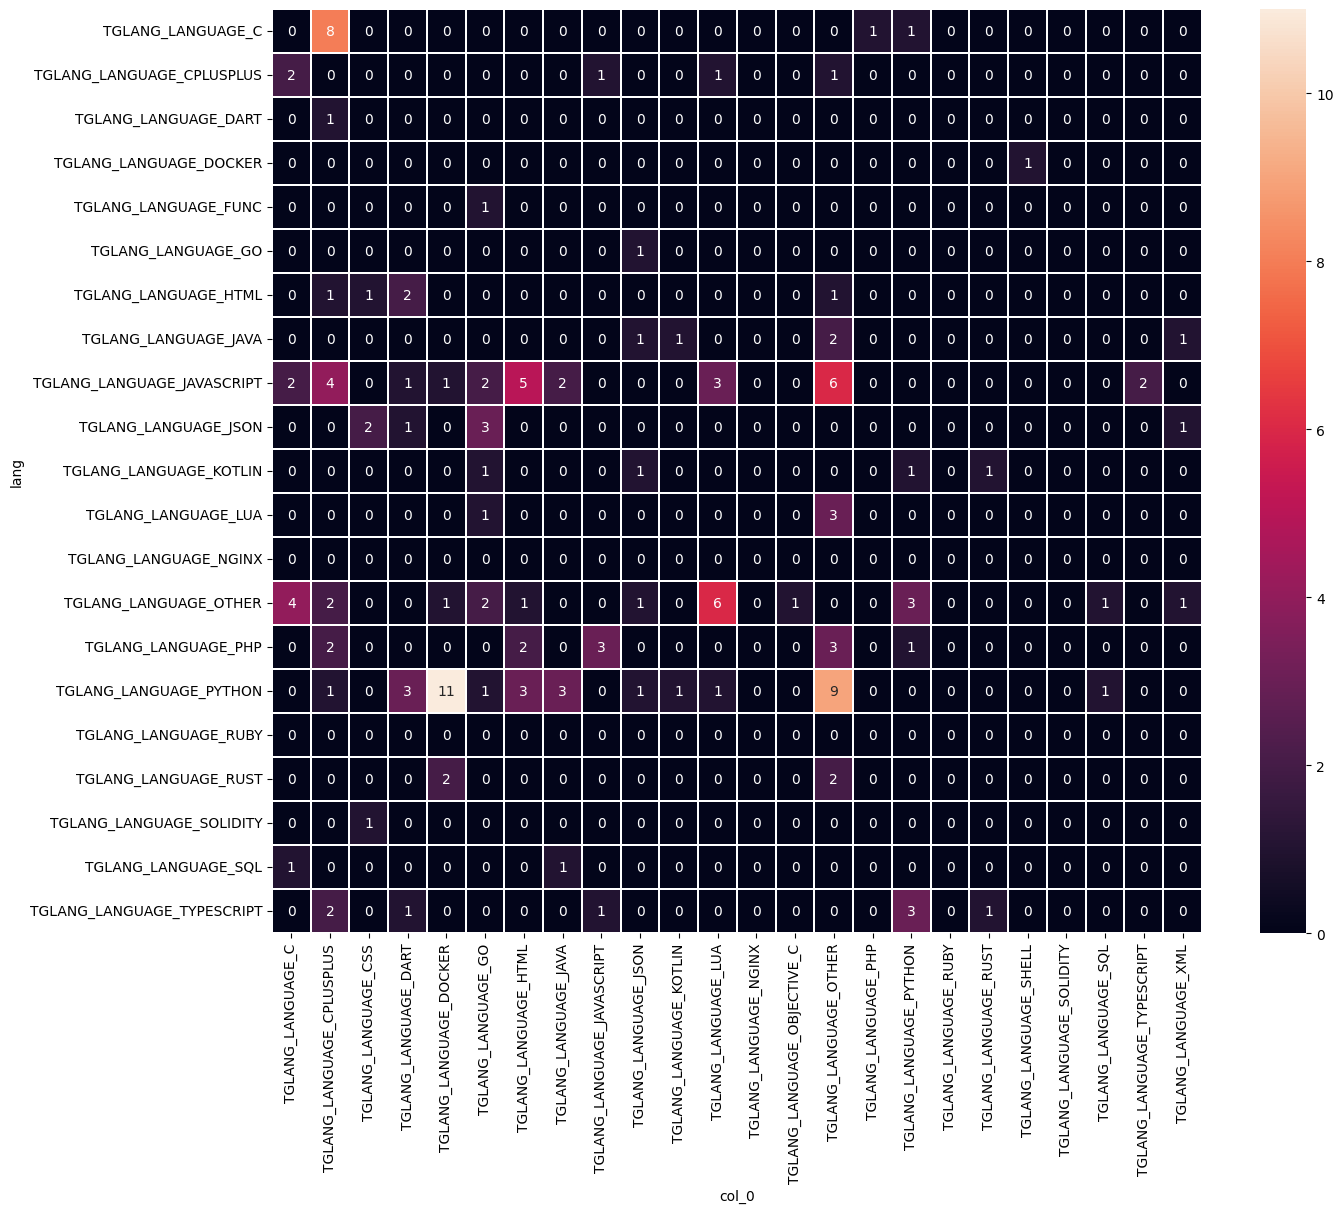

In [161]:
ct = pd.crosstab(y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(15,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [162]:
metrics = pd.DataFrame(classification_report(y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                            |   precision |   recall |   f1-score |    support |
|:---------------------------|------------:|---------:|-----------:|-----------:|
| TGLANG_LANGUAGE_FUNC       |    0        | 0        |   0        |   1        |
| TGLANG_LANGUAGE_DART       |    0.2      | 0.666667 |   0.307692 |   3        |
| TGLANG_LANGUAGE_TYPESCRIPT |    0.6      | 0.272727 |   0.375    |  11        |
| TGLANG_LANGUAGE_LUA        |    0.388889 | 0.636364 |   0.482759 |  11        |
| TGLANG_LANGUAGE_GO         |    0.352941 | 0.857143 |   0.5      |   7        |
| TGLANG_LANGUAGE_C          |    0.55     | 0.52381  |   0.536585 |  21        |
| TGLANG_LANGUAGE_DOCKER     |    0.4      | 0.909091 |   0.555556 |  11        |
| macro avg                  |    0.576643 | 0.609104 |   0.571898 | 985        |
| TGLANG_LANGUAGE_JAVA       |    0.6      | 0.642857 |   0.62069  |  14        |
| TGLANG_LANGUAGE_HTML       |    0.592593 | 0.761905 |   0.666667 |  21        |
| TGLANG_LANGUAG

#### Errors

In [163]:
TRUE_CLASS = "TGLANG_LANGUAGE_JAVA"
PRED_CLASS = None  #"TGLANG_LANGUAGE_CPLUSPLUS"

class_errors = test_set.loc[(y_test == TRUE_CLASS) & 
                                   ((test_pred == PRED_CLASS ) if PRED_CLASS else (test_pred != TRUE_CLASS))
                                  ]

for _, row in class_errors.iterrows():
    print("="*10, row["lang"], "="*10, end="\n\n")
    print(row["content"], end="\n\n")
    tokens = tokenize_text(row["content"],)
    print("VOCAB:", Counter([t for t in tokens if t in trainer.vect.vocabulary_]))
    
# print(*class_errors["content"].sample(3).tolist(), sep="\n\n=================================\n\n")

========== TGLANG_LANGUAGE_JAVA ==========

java -jar executable.jar -XmsN -XmxM --XX:UseZGC ... etc

VOCAB: Counter({'-': 3, 'jar': 2, 'java': 1, '.': 1, '--': 1, ':': 1, '...': 1, 'etc': 1})
========== TGLANG_LANGUAGE_JAVA ==========

java -jar executable.jar -XmsN -XmxM --XX:UseZGC ... etc

VOCAB: Counter({'-': 3, 'jar': 2, 'java': 1, '.': 1, '--': 1, ':': 1, '...': 1, 'etc': 1})
========== TGLANG_LANGUAGE_JAVA ==========

{"job":{"id":"zqxxesERxFivyBWt0O6OZXaxtSnzXKIK","class_fqn":"App\\Jobs\\Person\\PersonsMetricsMonitoringJob","class_name":"PersonsMetricsMonitoringJob","connection":"redis","queue":"PersonsMetricsMonitoringJob"},"connection":"redis","exception":"Illuminate\\Database\\QueryException"}

VOCAB: Counter({'":"': 7, '","': 5, '\\\\': 5, 'connection': 2, '{"': 1, 'job': 1, 'id': 1, 'App': 1, 'queue': 1, 'exception': 1, 'Illuminate': 1, 'Database': 1, '"}': 1})
========== TGLANG_LANGUAGE_JAVA ==========

<groupId>org.codehaus.mojo</groupId>
                <artifactId>axi

#### Vocab

In [164]:
trainer.vect.vocabulary_

{'*/': 176,
 'public': 1988,
 'static': 2204,
 'String': 821,
 '(': 100,
 'Activity': 397,
 'activity': 979,
 ')': 143,
 '{': 2471,
 '=': 324,
 '.': 197,
 '();': 125,
 ';': 309,
 'try': 2318,
 '(),': 121,
 ');': 161,
 'return': 2077,
 '}': 2482,
 'catch': 1138,
 'e': 1350,
 '"': 7,
 '";': 37,
 '@': 378,
 '_': 956,
 'err': 1390,
 'errors': 1392,
 'New': 691,
 '("': 103,
 'values': 2391,
 'post': 1948,
 'is': 1632,
 'not': 1837,
 'allowed': 996,
 '")': 18,
 'else': 1363,
 'value': 2390,
 ',': 185,
 'm': 1739,
 'Client': 458,
 '().': 123,
 'Get': 573,
 'ctx': 1260,
 'id': 1573,
 '})': 2484,
 '&': 65,
 '</': 319,
 'symbol': 2241,
 '>': 352,
 '<': 314,
 '--': 191,
 'Copyright': 480,
 'C': 436,
 'This': 848,
 'File': 556,
 'part': 1908,
 'of': 1853,
 'program': 1965,
 'free': 1482,
 'software': 2176,
 'you': 2466,
 'can': 1131,
 'redistribute': 2030,
 'it': 1636,
 'and': 1007,
 '/': 215,
 'or': 1874,
 'modify': 1794,
 'under': 2343,
 'the': 2269,
 'terms': 2260,
 'GNU': 569,
 'General': 570,

## Save models

### Full data re-training

In [165]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=True)


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### json export

In [166]:
import json

In [167]:
json_export_weights = {
    "vocabulary": list(trainer.vect.get_feature_names_out()),
    "idf_weights": list(trainer.vect.idf_),
    "classes": trainer.clf.classes_.tolist(),
    "class_log_prior": trainer.clf.class_log_prior_.tolist(),
    "feature_log_prob": trainer.clf.feature_log_prob_.tolist(),
}

In [168]:
with open("./models/trained/tglang.json", "w") as f:
    json.dump(json_export_weights, f)

### Torchscript

In [59]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple, Any

In [60]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = LANG_ENUM
        
    def to_dict(self,):
        return dict(
            feature_log_prior=self.feature_log_prior.tolist(),
            class_log_prior=self.class_log_prior.tolist(),
            class_labels=self.clf_labels,
            target_labels=self.target_labels
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
    
    def to_dict(self):
        return dict(
            vocab={k: v.tolist() for k,v in self.vocab.items()},
            idf_diag=self.idf_diag.tolist(),
            sublinear_tf=self.sublinear_tf,
            norm=self.norm,
            use_idf=self.use_idf,
        )

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [
            self.count_vocab(doc)
            for doc in batch
        ]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
    
    def to_dict(self):
        return dict(
            vect=self.vect.to_dict(),
            clf=self.clf.to_dict(),
        )
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.001:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions
    
    
class Tokenizer(nn.Module):
    def forward(self, docs: list[str]) -> list[list[str]]:
        return [tokenize_text(doc) for doc in docs]

#### export and chain

In [65]:

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)


# torchscript
tglang = torch.jit.script(tglang)

tokenizer = Tokenizer()
seq = nn.Sequential(
    tokenizer,
    tglang
)


#### review predictions

In [37]:
%%time 


batch = test_set.sample(5)
inputs = batch["content"].tolist()
gt = batch["lang"].tolist()



predictions = seq(inputs)

for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {LANG_ENUM[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp)
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_PYTHON'. True: 'TGLANG_LANGUAGE_PYTHON'

import geocoder

def get_lat_lon_by_ip(ip_address):
    g = geocoder.ip(ip_address)
    if g.latlng:
        latitude, longitude = g.latlng
        return latitude, longitude
    else:
        return None

# Example usage
ip_address = "123.456.789.0"  # Replace with the IP address you want to get the location for
location = get_lat_lon_by_ip(ip_address)
if location:
    latitude, longitude = location
    print(f"Latitude: {latitude}, Longitude: {longitude}")
else:
    print("Unable to get the location for the provided IP address.")

Predicted 'TGLANG_LANGUAGE_PYTHON'. True: 'TGLANG_LANGUAGE_PYTHON'

print(4)

Predicted 'TGLANG_LANGUAGE_OTHER'. True: 'TGLANG_LANGUAGE_OTHER'

— Скверны подобны животным, которые живут сегодняшним днем, не думая ни о прошлом, ни о будущем. — Делин развел руками. — Разве могли такие создания придумать столь дерзкий план? Разве они могли догадаться скрестить свой род с родом заклятых врагов,

#### Save to disk

In [38]:

path = 'models/trained/tglang.pt'
# tokenizer_path = path.replace("tglang.pt", "tglang_tokenizer.pt")
torch.jit.save(tglang, path)
# torch.jit.save(spe_scripted, tokenizer_path)
print('saved to', path)

saved to models/trained/tglang.pt


## Test jit

In [36]:
import torch

### Load model

In [37]:
%%time

path = 'models/trained/tglang.pt'

tokenizer = Tokenizer()
model = torch.jit.load(path)

model

CPU times: user 4.43 ms, sys: 1.22 ms, total: 5.65 ms
Wall time: 5.58 ms


RecursiveScriptModule(
  original_name=TgLang
  (vect): RecursiveScriptModule(original_name=TextVectorizer)
  (clf): RecursiveScriptModule(original_name=NaiveBayes)
)

### Check other

In [38]:
%%time

model_input = test_set[test_set["lang"] == LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_OTHER ==========
Bienvenido

========== TGLANG_LANGUAGE_OTHER ==========
FNT5

========== TGLANG_LANGUAGE_OTHER ==========
Каждое воскресенье в 14;30; Библиотека им. Куликова — ул. Гоголя, 183

========== TGLANG_LANGUAGE_OTHER ==========
37 🔑|     2 💫|     5 🍺
   11 💉|     4 📕|     2 🛌
    7 🧃|     6 🟣|     5 🔴
    8 🔵|     7 🟢|     1 💰
    9 👝|

CPU times: user 22.2 ms, sys: 6.93 ms, total: 29.2 ms
Wall time: 44.9 ms


### Check lang

In [40]:
%%time

model_input = test_set[test_set["lang"] != LANG_ENUM[0]]["content"].sample(4).tolist()
model_out = model(tokenizer(model_input))

for x, y in zip(model_input, model_out):
    print("="*10, LANG_ENUM[y], "="*10)
    print(x, end='\n\n')

========== TGLANG_LANGUAGE_C ==========
python
def calculate_hypotenuse(leg1, leg2):
    leg1_squared = leg1 ** 2
    leg2_squared = leg2 ** 2
    sum_of_squares = leg1_squared + leg2_squared
    hypotenuse = sum_of_squares ** 0.5
    return hypotenuse

========== TGLANG_LANGUAGE_HTML ==========
<div 
  class="some static classes"
  :classes="[...my, {[`dynamic--${color}`]: hasColor }]"
 />

========== TGLANG_LANGUAGE_JSON ==========
{
  "update_id": 256247932,
  "chat_member": {
    "chat": {
      "id": -1001818289494,
      "title": "ASTRONOT MOD OFFICIAL",
      "username": "astronotmod",
      "type": "channel"
    },
    "from": {
      "id": 5065199935,
      "is_bot": false,
      "first_name": "`Zacky",
      "last_name": "[NC]"
    },
    "date": 1696675329,
    "old_chat_member": {
      "user": {
        "id": 5065199935,
        "is_bot": false,
        "first_name": "`Zacky",
        "last_name": "[NC]"
      },
      "status": "member"
    },
    "new_chat_member": {
   

In [51]:
TEXT = """<div 
  class="some static classes"
  :classes="[...my, {[`dynamic--${color}`]: hasColor }]"
 />"""

tokenizer_out = tokenizer([TEXT])
vectorizer_out = model.vect(tokenizer_out)
clf_out = model.clf(vectorizer_out)

In [55]:
with open("./models/trained/example_output.json", 'w') as f:
    json.dump(dict(
        text=TEXT,
        tokenizer_out=tokenizer_out,
        vectorizer_out=vectorizer_out.tolist(),
        clf_out=clf_out.tolist()
        ), f)

### Check file sizes

In [104]:
!du -h models/trained/* | sort -nr

616K	models/trained/tglang.pt
384K	models/trained/tglang_spe_unigram_10000.torchscript
380K	models/trained/tglang_spe_unigram_10000.model
156K	models/trained/tglang_spe_unigram_10000.vocab
8.1M	models/trained/tglang_l.pt
4.0K	models/trained/example_output.json
2.1M	models/trained/tglang_m.pt
